In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm
from scipy.integrate import odeint
from data import get_orbit,random_config,sample_orbits
from scipy.integrate import odeint
from torchdiffeq import odeint_adjoint as todeint
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import os.path


## Dataset generation and initialization
- The following code should take about ~10 minutes to run assuming you do not have the data already downloaded

In [2]:
class PlanetaryData(Dataset):
    def __init__(self, x, dxdt):
        self.x = x
        self.dxdt = dxdt
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.dxdt[idx]
fname = "smaller_dataset"
if not os.path.isfile(f"{fname}_x_coords.pt"):

    data,_ = sample_orbits(time_steps = 80,trials = 5000,t_span=[0,20])
    x = torch.tensor( data['coords'], requires_grad=True, dtype=torch.float32)
    # test_x = torch.tensor( data['test_coords'], requires_grad=True, dtype=torch.float32)
    dxdt = torch.Tensor(data['dcoords'])
    torch.save(x,f"{fname}_x_coords.pt")
    torch.save(dxdt,f"{fname}_dxdt_vals.pt")
else:
    x = torch.load(f"{fname}_x_coords.pt")
    dxdt = torch.load(f"{fname}_dxdt_vals.pt")

In [3]:
dset = PlanetaryData(x,dxdt)
print(f"Dataset has {len(dset)} examples")
epochs = 4
batch_size  = 64
dloader = DataLoader(dset,batch_size,shuffle=True)

Dataset has 100000 examples


## Model implementations
- Here are a bunch of the different models I tried to train. The best one is definitely the hnn

In [ ]:
class NueODENode(nn.Module):
    """Wrapepr class in order to run odeint from torchdiffeq
    """
    def __init__(self,layer):
        super(NueODENode, self).__init__()
        self.layer = layer

    def forward(self,t,S):
        """This is how the function needs to be formatted in order to use odeint from torchdiffeq

        Args:
            t (integer): The time step
            S (torch.Tensor): The current state of the system
        """
        return self.layer(S)
    
class NerualODE(nn.Module):
    """Implementation of NeuralODE
    """
    def __init__(self):
        super(NerualODE, self).__init__()
        # Make an in-layer that transforms the features to fit the ODE
        self.in_layer = nn.Linear(12,200)

        # This is the update function for the neural ODE
        self.update_fn = nn.Sequential(nn.Linear(200,200),nn.Tanh())
        # We need to pass it into a wrapper class to make sure everything works correctly
        self.node = NueODENode(self.update_fn)
        self.out = nn.Linear(200,1)

    def forward(self,x):
        # Turn everything to the right size
        x = self.in_layer(x)
        # Run the update method
        x = todeint(self.node,x,torch.linspace(0,3,4))
        # Transform it back
        return self.out(x)

class HNN(torch.nn.Module):
    """Generic class to implement predicting the derivative of the three body system
    """
    def __init__(self, input_dim,nn_type="Hamiltonian"):
        super(HNN, self).__init__()
        output_dim = input_dim if nn_type == "Feedforward" else 1
        if nn_type == "NeuralODE":
            self.layers =NerualODE()
        elif nn_type == "Hamiltonian" or nn_type == "Feedforward":
            self.layers = nn.Sequential(nn.Linear(input_dim,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,output_dim))
        else:
            raise ValueError(f"{nn_type} is not a valid type please choose between Hamiltonian, Feedforward or NeuralODE")
        self.nn_type = nn_type

        # We make a permutation matrix M to later permute the derivatives so our loss acheives:
        # dp/dt=-dH/dq, dq/dt=dH/dp
        M = torch.eye(input_dim)
        self.M = torch.cat([M[input_dim//2:], -M[:input_dim//2]]) 

    def forward(self, x):
        # We just pass it through the layers
        return self.layers(x)

    def time_derivative(self, x, t=None):
        """Returns the prediction of our function

        Args:
            x (torch.Tensor): The state of the system
            t (torch.Tensor, optional): The current time step. Defaults to None.
        """
        # IF we are just doing a feedforward we try to predict the derivatives directly
        if self.nn_type == "Feedforward":
            return self.layers(x)

        # Otherwise we calculate -dH/dq as our prediction for dp/dt and dH/dp as our prediction for dq/dt
        F2 = self.forward(x) 

        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] 
        hamiltonian_derivative = dF2 @ self.M.T

        return hamiltonian_derivative


# Baseline HNN
- The following code trains the model using MSE loss
- It takes ~4 minutes to run

100%|██████████| 1563/1563 [03:10<00:00,  8.21it/s]


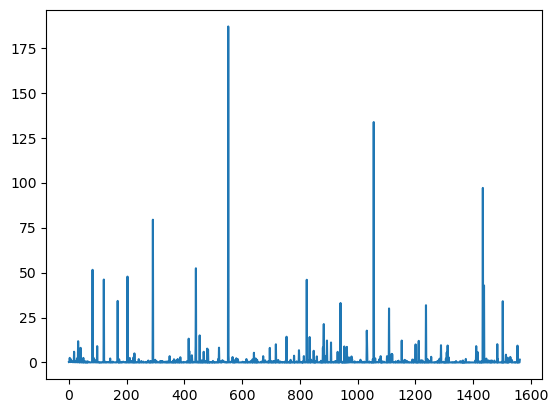

In [9]:
epochs = 1
model = HNN(12)
opt = torch.optim.Adam(model.parameters(),1e-3)
losses = []
for epoch in range(epochs):
    for x,dxdt in tqdm(dloader):
        opt.zero_grad()
        pred = model.time_derivative(x)
        loss = F.mse_loss(pred,dxdt)
        loss.backward()
        opt.step()
        losses.append(loss.item())
plt.plot(losses)
plt.show()

In [44]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,3).T
    return deriv.reshape(-1)
num_steps = 1000
time_span = [0,40]
file_name = "Feedforward_prediction"
update_fn = lambda t, y0: model_update(t, y0, model)
state = random_config(nu=1e-2, min_radius=.9, max_radius=1.2)
v, settings = get_orbit(state, t_points=num_steps, t_span=time_span, update_fn=update_fn)
true_orbit,_ =get_orbit(state, t_points=num_steps, t_span=time_span)


positions_approx = v.transpose(2,0,1)[:,:,1:3]
positions= true_orbit.transpose(2,0,1)[:,:,1:3]
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), positions_approx[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), positions_approx[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])
        trajectories_approx[j].set_data(positions_approx[:i, j, 0], positions_approx[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=num_steps, init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=30)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()

# Equivariant Hamiltonian

In [4]:
from itertools import permutations
class EquivariantHNN(torch.nn.Module):
    """Generic class to implement predicting the derivative of the three body system
    """
    def __init__(self, input_dim):
        super(EquivariantHNN, self).__init__()
        self.layers = nn.Sequential(nn.Linear(15,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,200),
                                                  nn.Tanh(),
                                                  nn.Linear(200,1))

        # We make a permutation matrix M to later permute the derivatives so our loss acheives:
        # dp/dt=-dH/dq, dq/dt=dH/dp
        M = torch.eye(input_dim)
        self.M = torch.cat([M[input_dim//2:], -M[:input_dim//2]]) 

    def equivariant_fn(self,x):
        # print(x.shape)
        p1 = x[:,[True,False,False,True,False,False]+[False]*6]
        p2 = x[:,[False,True,False,False,True,False]+[False]*6]
        p3 = x[:,[False,False,True,False,False,True]+[False]*6]
        s1 = x[:,[False]*6+[True,False,False,True,False,False]]
        s2 = x[:,[False]*6+[False,True,False,False,True,False]]
        s3 = x[:,[False]*6+[False,False,True,False,False,True]]

        ps = [p1,p2,p3]
        ss = [s1,s2,s3]
        perms = permutations([1,2,0])

        # Cycling through each permutation ensures invariance under permutation
        outs = 0
        for perm in perms:
            # print(perm)
            p_1,p_2,p_3 = ps[perm[0]],ps[perm[1]],ps[perm[2]]
            s_1,s_2,s_3 = ss[perm[0]],ss[perm[1]],ss[perm[2]]

            # This ensures invariance under translation
            p_2 =p2- p_1
            p_3 = p_3-p_1

            # This ensures invariance under rotation
            units = [p_2,p_3,s_1,s_2,s_3]
            inner_prods = []
            for i  in range(len(units)):
                for j in range(i,len(units)):
                    inner_prods.append((units[i]*units[j]).sum(dim=-1))
            inner_prods = torch.dstack(inner_prods).squeeze(0)
            outs+= self.layers(inner_prods)
        return outs/6

    def forward(self, x):
        # We just pass it through the layers
        return self.equivariant_fn(x)

    def time_derivative(self, x, t=None):
        """Returns the prediction of our function

        Args:
            x (torch.Tensor): The state of the system
            t (torch.Tensor, optional): The current time step. Defaults to None.
        """

        # We calculate -dH/dq as our prediction for dp/dt and dH/dp as our prediction for dq/dt
        F2 = self.forward(x) 

        dF2 = torch.autograd.grad(F2.sum(), x, create_graph=True)[0] 
        hamiltonian_derivative = dF2 @ self.M.T

        return hamiltonian_derivative

In [7]:
epochs = 1
model = EquivariantHNN(12)
opt = torch.optim.Adam(model.parameters(),1e-3)
losses1 = []
losses2 = []
for epoch in range(epochs):
    for x,dxdt in tqdm(dloader):
        opt.zero_grad()
        pred = model.time_derivative(x)
        loss1 = F.mse_loss(pred[:,:3],dxdt[:,:3])
        loss2= F.mse_loss(pred[:,3:],dxdt[:,3:])
        loss = loss1+loss2**2
        loss.backward()
        opt.step()
        losses1.append(loss1.item())
        losses2.append(loss2.item())
plt.plot(losses1)
plt.show()
plt.plot(losses2)

  0%|          | 6/1563 [00:00<04:15,  6.08it/s]

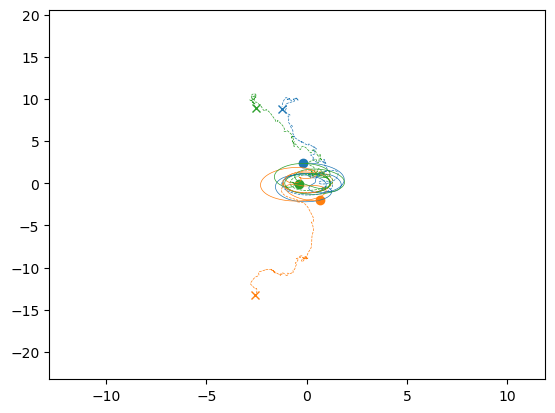

In [6]:
def model_update(t, state, model):
    state = state.reshape(-1,5)

    deriv = np.zeros_like(state)
    np_x = state[:,1:] # drop mass
    np_x = np_x.T.flatten()[None, :]
    x = torch.tensor( np_x, requires_grad=True, dtype=torch.float32)
    dx_hat = model.time_derivative(x)
    deriv[:,1:] = dx_hat.detach().data.numpy().reshape(4,3).T
    return deriv.reshape(-1)
num_steps = 500
time_span = [0,40]
file_name = "equivariant_prediction"
update_fn = lambda t, y0: model_update(t, y0, model)
state = random_config(nu=1e-2, min_radius=.9, max_radius=1.2)
v, settings = get_orbit(state, t_points=num_steps, t_span=time_span, update_fn=update_fn)
true_orbit,_ =get_orbit(state, t_points=num_steps, t_span=time_span)


positions_approx = v.transpose(2,0,1)[:,:,1:3]
positions= true_orbit.transpose(2,0,1)[:,:,1:3]
# Animation
# Animation setup
fig, ax = plt.subplots()
ax.set_xlim(-30, 30)
ax.set_ylim(-30, 30)

# Original positions visualized with 'o' markers and solid lines for trajectories
lines = [ax.plot([], [], 'o')[0] for _ in range(3)]
# Store colors for reuse with approximated trajectories
colors = [f"C{_}" for _ in range(3)]
trajectories = [ax.plot([], [], '-', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

# Approximated positions visualized with 'x' markers and dotted lines for trajectories
# Use the same colors as the original trajectories
lines_approx = [ax.plot([], [], 'x', color=colors[_])[0] for _ in range(3)]
trajectories_approx = [ax.plot([], [], '--', linewidth=0.5, color=colors[_])[0] for _ in range(3)]

def init():
    for line in lines + lines_approx:
        line.set_data([], [])
    for traj in trajectories + trajectories_approx:
        traj.set_data([], [])
    return lines + trajectories + lines_approx + trajectories_approx

def animate(i):
    if len(positions[:i,:,0]) != 0:
        all_x = np.concatenate((positions[:i, :, 0].flatten(), positions_approx[:i, :, 0].flatten()))
        all_y = np.concatenate((positions[:i, :, 1].flatten(), positions_approx[:i, :, 1].flatten()))
        min_x, max_x = all_x.min() - 10, all_x.max() + 10
        min_y, max_y = all_y.min() - 10, all_y.max() + 10
        ax.set_xlim(min_x, max_x)
        ax.set_ylim(min_y, max_y)

    for j, (line, line_approx) in enumerate(zip(lines, lines_approx)):
        # Update original positions and trajectories
        line.set_data(positions[i, j, 0], positions[i, j, 1])
        trajectories[j].set_data(positions[:i, j, 0], positions[:i, j, 1])
        
        # Update approximated positions and trajectories
        line_approx.set_data(positions_approx[i, j, 0], positions_approx[i, j, 1])
        trajectories_approx[j].set_data(positions_approx[:i, j, 0], positions_approx[:i, j, 1])

    return lines + trajectories + lines_approx + trajectories_approx

# Assuming num_steps is defined
ani = animation.FuncAnimation(fig, animate, frames=num_steps, init_func=init, blit=True, interval=1)

# To save the animation
writergif = animation.PillowWriter(fps=30)
ani.save(f'{file_name}.gif', writer=writergif)

plt.show()